# RKDE (Robust Kernel Density Estimation)

## Generating  the data set

In [39]:
import numpy as np 
import matplotlib.pyplot as plt

# Define the number of points
n_samples = 100

mu1, sigma1 = 0,1 # mean and variance
mu2, sigma2 = 10,1

x1 = np.random.normal(mu1,np.sqrt(sigma1),n_samples)
x2 = np.random.normal(mu2,np.sqrt(sigma2),n_samples)

def pdf(loc,variance,observation):
    '''Giving the Probability Density Function

    Parameters
    ----------
        loc (Int): Mean of the distribution ; where the peak of the bell exists
        variance(Int) : variance
        sample (Array) : the distribution

    Returns
    -------
        ndrray: Gaussian distribution
    '''
    # A normal continuous random variable.
    s1 = 1/(np.sqrt(2*np.pi*variance))
    s2 = np.exp(-(np.square(observation - loc)/(2*variance)))
    return s1 * s2 

# Adding outliers
outliers = np.random.randint(-5,15,40)
""" x1 = np.append(x1,outliers[:21])
x2 = np.append(x2,outliers[21:])
 """
X = np.array(list(x1) + list(x2))
X = np.append(X, outliers)
np.random.shuffle(X)
print("Dataset Shape: ", X.shape)

Dataset Shape:  (240,)


### Visualize the training data

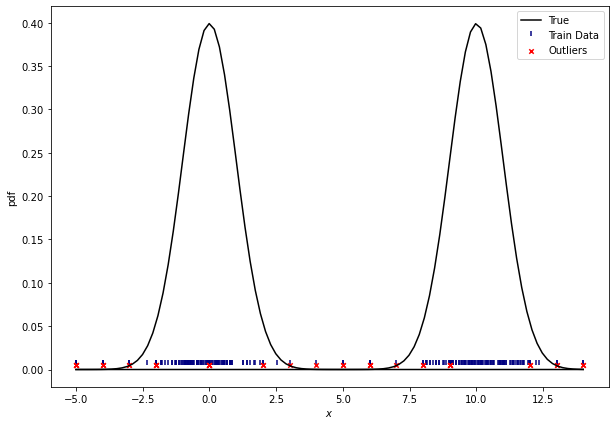

In [40]:
bins = np.linspace(np.min(X),np.max(X),100)

plt.figure(figsize=(10,7))
plt.xlabel("$x$")
plt.ylabel("pdf")

plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")


plt.plot(bins, pdf(mu1,sigma1,bins), color='black', label="True")
plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

plt.legend()
plt.show()

## Applying KDE (Kernel Density Estimation)

ValueError: x and y must have same first dimension, but have shapes (100,) and (200,)

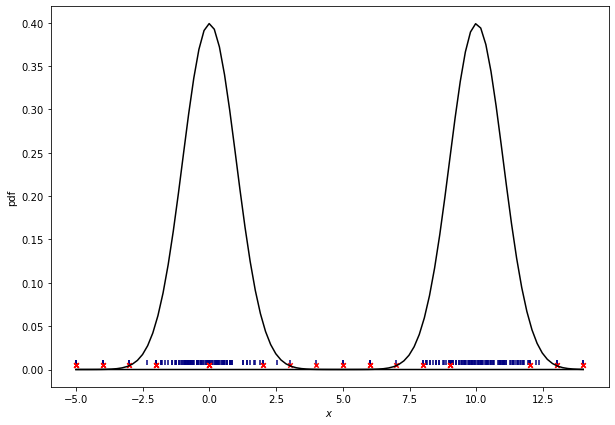

In [41]:
def kernel_function(obs,givenData,variance,d=1):
    """ Kernel Function

    Parameters
    ----------
        obs (Int): Observation data
        variance (Int): variance of the distribution
        d (Int, optional): dimension
        givenData (Int): Gaussian value
    
    Returns
    -------
        Int: kernel value   
    """
    result = np.exp((-1/2)* ((obs - givenData)/variance)**2)
    return result

def kernel_density_function(obs_data,givenData,variance=1,d=1):
    '''Kernel Density Function
    Parameters
    ----------
        obs_data (Array): Observation data  
        h (Int): windows size
        d (Int, optional): dimension
        givenData (Array): Gaussian values

    Returns
    -------
      Array: new data after applying kdf
    '''
    final_result = []
    # Size of the gaussian data
    size = len(givenData)
    for obs in obs_data:
        k_result = 0
        for g in givenData:
            k_result +=  ((1/ (size * (variance**2 * 2*np.pi)**(d/2)))* kernel_function(obs,g,variance))
        final_result.append(k_result)
    return final_result

plt.figure(figsize=(10,7))
plt.xlabel("$x$")
plt.ylabel("pdf")

plt.scatter(X,[.005] * len(X), color='navy', s=30, marker=2, label="Train Data")
plt.scatter(outliers,[.005] * len(outliers), color='red', s=20, marker='x', label="Outliers")

plt.plot(bins, pdf(mu1,sigma1,bins), color='black', label="True")
plt.plot(bins, pdf(mu2,sigma2,bins), color='black')

X_kde = kernel_density_function(bins,(X),np.sqrt(sigma1))
#X_kde2 = kernel_density_function(bins,(x2))

plt.plot(bins, X_kde, color='blue', label="KDE", dashes=[6,2])
#plt.plot(bins, X_kde2, color='blue', dashes=[6,2])

plt.legend()
plt.show()

In [ ]:
def generate_weights(_sum,n):
    mean = _sum / n
    variance = float(.25 * mean)

    min_v = mean - variance
    max_v = mean + variance

    array = [min_v] * n

    diff = _sum - min_v * n
    while diff > 0 :
        a = np.random.randint(0,n-1)
        if array[a] >= max_v:
            continue
        array[a] += 1
        diff -= 1
    return array

weigths = generate_weights(100,240)
#numbers = np.random.multinomial(100,np.ones(240)/240, size=1)[0]
print(weigths)
print(sum(weigths))

[0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 1.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 1.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 1.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 1.3125, 0.3125, 0.3125, 1.3125, 1.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 1.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 1.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 1.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 1.3125, 0.3125,